# Project 3: Web APIs & Classification

## Problem Statement

Nvidia is the top player in Garphic processors and AMD is trying to penetrate to gain market share in GPU. Data Science team at Nvidia keeps a track of reviews and comments across various social platforms, including Reddit post of Amd and Nvidia. The database keeps Nvidia product managers updated on what consumers are currently interested in. However, some internal system  failure caused the data of posts to get mixed up and loose the classification.

Nvidia Data science team had been given a task to classify Reddit posts of r/Nvidia and r/Amd. Natural Language Processing (NLP) and classification models, mainly Logistic Regression and Naive Bayes were used to make the binary classification. The final model will be selected based on the accuracy and ROC AUC scores. The model choosen achieved an accuracy of 0.89 and AUC of 0.88 and. This is crucial as the product managers need to know what people are discussing on both the subreddits.

Besides aiming for accuracy of our prediction, we wanted to target whether there are discussions around Amd or Nvidia so we can define the success that is evaluated by the model which has the highest score that combines both accuracy and AUC ROC score.

## Executive Summary¶
Using Reddit's API, we will be scraping posts through the subreddits of Nvidia and AMD using the 'requests' library. We used a for loop to extract posts via json and gave a randomised sleep duration between each loop. Randomised sleep helps server to not overload.

After examining the scraped data, we see that the posts selftext and the title both hold meaningful words for our analysis. We cleaned the posts by dropping the empty selftext and duplicate posts. We will do pre-processing of posts and EDA  to check the most frequent words in the posts and the length of the posts. After combining the posts, we were left with the 2590 posts. 

We have used 4 models include the CountVectorizer & Logistic Regression, TF-IDF & Logistic Regression, CountVectorizer & Naive Bayes and TF-IDF & Naive Bayes. GridSearchCV was used to optimise the model hyperparameters which were tuned to optimise accuracy and prevent overfitting. Comparing to the baseline score of 0.58, with all the models to find out the best model to decide on the accuracy. 

Count Vectorizer & Naive Bayes classifier model achieves an accuracy of 0.88 and an AUC score 0.88. We can conclude that the |**CountVectorizer & Naive Bayes classifier**| is the best model with high score and Accuracy.

As mentioned in the problem statement, we are interested to find out whether the post is coming from Amd or Nvidia subreddit. The goal over here is to focus on the |**accuracy & AUC ROC score of the model**|.

|**Contents**|:
- Importing Libraries
- Load Data
- Modelling
- Model #1: Count Vectorizer & Logistic Regression
- Model #2: TF-IDF & Logistic Regression
- Model #3: Count Vectorizer & Naive Bayes
- Model #4: TF-IDF & Naive Bayes
- Model Evaluation
- Model Evaluation: Confusion Matrix & Classification Report
-  ROC AUC plot 
- Identifying the Most Predictive Words
- Misclassified Data
- Conclusion and Recommendations

In [239]:
# Import the libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import random
import pylab as pl

pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

import re
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, accuracy_score, confusion_matrix

In [240]:
# Read cobmined CSV file 
df = pd.read_csv('./datasets/combined.csv')

In [241]:
df.head()

,subreddit,selftext,title,num_comments,selftext_clean,title_clean,selftext_title_clean,selftext_len
0,nvidia,# [This thread is best viewed on New Reddit pl...,Read Me First - Event Protocol for r/NVIDIA Co...,273,thread best view new reddit platform new reddi...,read first event protocol r commun septemb st,thread best view new reddit platform new reddi...,232
1,nvidia,This is my first time following along with the...,One More Day! Who’s hyped?!,566,first time follow along launch new gener graph...,one day hype,first time follow along launch new gener graph...,25
2,nvidia,I plan to get a 3080 tomorrow assuming I can p...,Why get a non founders or reference card?,105,plan get tomorrow assum pre order coars sure b...,get non founder refer card,plan get tomorrow assum pre order coars sure b...,39
3,nvidia,I’m hoping to get an EVGA 3090 tomorrow but no...,"If AIB cards launch tomorrow as predicted, do ...",121,hope get evga tomorrow sure f ing best result ...,aib card launch tomorrow predict buy manufactu...,hope get evga tomorrow sure f ing best result ...,10
4,nvidia,I’m curious as I can’t really decide myself. L...,Which 3000 series card manufacturer are you go...,270,curiou realli decid love ti strix might go tea...,seri card manufactur go choos,curiou realli decid love ti strix might go tea...,30


In [242]:
# Assign nvidia as class 0 and Amd as class 1
df['subreddit'] = df['subreddit'].map({'nvidia':0, 'Amd': 1})

In [243]:
# Check that we have mapped the subreddits correctly
df['subreddit'].value_counts()

0    1518
1    1072
Name: subreddit, dtype: int64

In [244]:
# Establish our baseline score 
# As 0.58 shall be the baseline accuracy 
df['subreddit'].value_counts(normalize=True)

0    0.5861
1    0.4139
Name: subreddit, dtype: float64

Our classes relatively balanced. Given that the majority class is class 0, our baseline score is an accuracy of 0.5861. The baseline score will serve as a point of comparison when evaluating our models.

In [245]:
# Import train_test_split.
from sklearn.model_selection import train_test_split


# Import logistic & linear regression
from sklearn.linear_model import  LogisticRegression

In [246]:
# Define y and X.
X = df['selftext_title_clean']
y = df['subreddit']

# Perform train test split so that we can train, score and tune our models' hyperparameters 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [247]:
X_train.shape

(2072,)

In [248]:
y_test.shape

(518,)

In [249]:
# Check split in class labels for y_train
y_train.value_counts(normalize=True)

0    0.585907
1    0.414093
Name: subreddit, dtype: float64

In [250]:
# Check split in class labels for y_test
y_test.value_counts(normalize=True)

0    0.586873
1    0.413127
Name: subreddit, dtype: float64

|**Stratification**| ensured that our train_test_split method returns training and test sets that have the same proportion of class labels as the input dataset.

The following 4 models will be built and scored against the train and test set:
 - Count Vectorizer & Logistic Regression,
 - TF-IDF & Logistic Regression,
 - Count Vectorizer & Naive Bayes 
 - TF-IDF & Naive Bayes

##  Model #1: Count Vectorization & Logistic Regression

In [251]:
# Create a pipeline with CountVectorizer and LogisticRegression
pipe1 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('lr', LogisticRegression())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 400, 600
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Logistic regression penalty: l2 - Ridge
pipe1_params = {
   'cvec__max_features': [200,400], # Will be very overfitted if max_features = 1000
    'cvec__min_df': [2,3], 
     'cvec__max_df': [.95,.9], 
    'cvec__ngram_range':[(1,1),(1,2)], # Not much impact
    'lr__penalty': ['l2'],
    'lr__C' : [.01,.1]
    }
    
# Instantiate GridSearchCV
gs_cvec_lr = GridSearchCV(pipe1, # Objects to optimise
                          param_grid = pipe1_params, # Hyperparameters for tuning
                          cv=5) # 5-fold cross validation

# Fit GridSearch to training data
gs_cvec_lr.fit(X_train,y_train)
preds = gs_cvec_lr.predict(X_test)
# Print results
print('Best parameters: ', gs_cvec_lr.best_params_)
print('Best score: ', gs_cvec_lr.best_score_)
print('Training score:', gs_cvec_lr.score(X_train, y_train))
print('Test score:', gs_cvec_lr.score(X_test, y_test))
print('ROC score:', roc_auc_score(y_test, preds))
print('Accuracy:', accuracy_score(y_test, preds))

Best parameters:  {'cvec__max_df': 0.95, 'cvec__max_features': 400, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'lr__C': 0.1, 'lr__penalty': 'l2'}
Best score:  0.8774157499563471
Training score: 0.9208494208494209
Test score: 0.8957528957528957
ROC score: 0.8848991637973439
Accuracy: 0.8957528957528957


### Observation:
When the Count Vectorizer was given max_features of 1000, the training score 0.97 is indication of overfitting. Tuned the hyperparameters to find the minumum overfitting. With max_features of 400 the training score 0.92 and test score is 0.89

##  Model #2: TF-IDF & Logistic Regression

In [252]:
# Create a pipeline with TF-IDF and LogisticRegression
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 100, 200
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Logistic regression penalty: l2 - Ridge
pipe2_params = {
    'tvec__max_features': [200,400], # Will be very overfitted if max_features = 1000
    'tvec__min_df': [2,3], #10,20
    'tvec__max_df': [.9,.95],
#    'tvec__ngram_range':[(1,1),(1,2)],
    'lr__penalty':['l2'],
    'lr__C' : [.1,1]
     }

# Instantiate GridSearchCV
gs_tvec_lr = GridSearchCV(pipe2, # Objects to optimise
                          param_grid = pipe2_params, # Hyperparameters for tuning
                          cv=5) # 5-fold cross validation

# Fit GridSearch to training data
gs_tvec_lr.fit(X_train,y_train)
preds= gs_tvec_lr.predict(X_test)

print('Best parameters: ', gs_tvec_lr.best_params_)
print('Best score: ', gs_tvec_lr.best_score_)
print('Training score:', gs_tvec_lr.score(X_train, y_train))
print('Test score:', gs_tvec_lr.score(X_test, y_test))
print('ROC score:', roc_auc_score(y_test, preds))
print('Accuracy:', accuracy_score(y_test, preds))

Best parameters:  {'lr__C': 1, 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': 400, 'tvec__min_df': 2}
Best score:  0.8856213258832429
Training score: 0.9198841698841699
Test score: 0.8918918918918919
ROC score: 0.8809179783571077
Accuracy: 0.8918918918918919


### Observation:
TF-IDF & Logistic regression is |**slightly ledd overfitted**| and has better score.Using TF-IDF gave greater importance to words that occurred more frequently in the same document and gave lower importance to words that appeared a lot across documents. In the current reddit post this has not given better score and accuracy to improve the score. 

## Model-3: Count Vectorizer and Naive Bayers

In [253]:
# Create a pipeline with CountVectorizer and Naive Bayes
pipe3 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 200,600
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
pipe3_params = {
    'cvec__max_features': [500, 1000],
    'cvec__min_df': [2,3], 
    'cvec__max_df': [.9,.95],
   'cvec__ngram_range':[(1,1),(1,2)],

    }

# Instantiate GridSearchCV
gs_cvec_nb = GridSearchCV(pipe3, # Objects to optimise
                          param_grid = pipe3_params, # Hyperparameters for tuning
                          cv=5) # 5-fold cross validation

# Fit GridSearch to training data
gs_cvec_nb.fit(X_train,y_train)
preds =gs_cvec_nb.predict(X_test)

print('Best parameters: ', gs_cvec_nb.best_params_)
print('Best score: ', gs_cvec_nb.best_score_)
print('Training score:', gs_cvec_nb.score(X_train, y_train))
print('Test score:', gs_cvec_nb.score(X_test, y_test))
print('ROC score:', roc_auc_score(y_test, preds))
print('Accuracy:', accuracy_score(y_test, preds))

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1)}
Best score:  0.8759641464408358
Training score: 0.9078185328185329
Test score: 0.8822393822393823
ROC score: 0.8823782587309396
Accuracy: 0.8822393822393823


#### Observation:
The CountVectorizer and Naive Bayes model observes a better training and test accuracy achieving a training score of 0.907 and test score of 0.882 This .Naive Bayer with Countvectorizer performed similar to Logistic regression with ROC score of 0.88 and Accuracy 0.882. We have to keep in mind that Naive Bayer model operates under the assumption that the predictors are independent of each other which may not be the case in real scenario. 

## Model 4: TFID Vectorizer & Naive Bayer¶

In [254]:
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 500,1000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
pipe4_params = {
    'tvec__max_features': [500,1000], 
    'tvec__min_df': [2,3], 
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range':[(1,1),(1,3)]
    
}

# Instantiate GridSearchCV
gs_tvec_nb = GridSearchCV(pipe4, # Objects to optimise
                          param_grid = pipe4_params, # Hyperparameters for tuning
                          cv=5) # 5-fold cross validation

# Fit GridSearch to training data
gs_tvec_nb.fit(X_train,y_train)
preds= gs_tvec_nb.predict(X_test) 

print('Best parameters: ', gs_tvec_nb.best_params_)
print('Best score: ', gs_tvec_nb.best_score_)
print('Training score:', gs_tvec_nb.score(X_train, y_train))
print('Test score:', gs_tvec_nb.score(X_test, y_test))
print('ROC score:', roc_auc_score(y_test, preds))
print('Accuracy:', accuracy_score(y_test, preds))

Best parameters:  {'tvec__max_df': 0.9, 'tvec__max_features': 500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}
Best score:  0.8658320237471626
Training score: 0.8904440154440154
Test score: 0.8571428571428571
ROC score: 0.846470732907034
Accuracy: 0.8571428571428571


#### Observation:
Th TF-IDF and Naive Bayes model observes a overfitting with  training score as 0.890 and test test score of 0.857.Training score reduced to 0.85 and ROC score 0.846 which means the model will not perform well on testing data. 

## Model Evaluation

## Model Evaluation: Confusion Matrix & Classification Report

In [255]:
# Predictions across 4 models
cvec_lr_pred = gs_cvec_lr.predict(X_test)
tvec_lr_pred = gs_tvec_lr.predict(X_test)
cvec_nb_pred = gs_cvec_nb.predict(X_test)
tvec_nb_pred = gs_tvec_nb.predict(X_test)

Logistic Reg & Count Vectorization
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       304
           1       0.92      0.82      0.87       214

    accuracy                           0.90       518
   macro avg       0.90      0.88      0.89       518
weighted avg       0.90      0.90      0.89       518



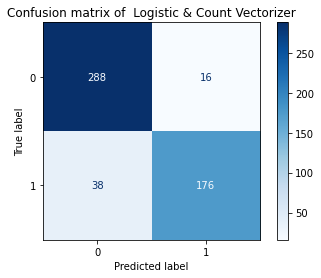

In [256]:
# Confusion matrix of all the four models to look at the number  of  misclassified posts

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gs_cvec_lr, X_test, y_test, cmap='Blues', values_format='d');
pl.title('Confusion matrix of  Logistic & Count Vectorizer')
print('Logistic Reg & Count Vectorization\n' + classification_report(y_test,cvec_lr_pred ))

Logistic Reg & TF-IDF
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       304
           1       0.91      0.82      0.86       214

    accuracy                           0.89       518
   macro avg       0.90      0.88      0.89       518
weighted avg       0.89      0.89      0.89       518



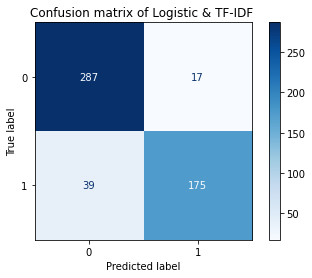

In [257]:
plot_confusion_matrix(gs_tvec_lr, X_test, y_test, cmap='Blues', values_format='d');
pl.title('Confusion matrix of Logistic & TF-IDF ')
print('Logistic Reg & TF-IDF\n' +classification_report(y_test,tvec_lr_pred ))

Naive Bayer & TF-IDF
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       304
           1       0.84      0.88      0.86       214

    accuracy                           0.88       518
   macro avg       0.88      0.88      0.88       518
weighted avg       0.88      0.88      0.88       518



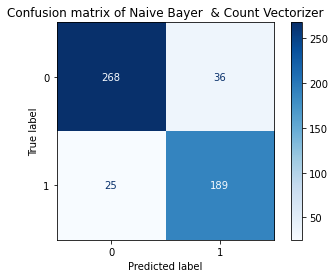

In [258]:

plot_confusion_matrix(gs_cvec_nb, X_test, y_test, cmap='Blues', values_format='d');
pl.title('Confusion matrix of Naive Bayer  & Count Vectorizer')
print('Naive Bayer & TF-IDF\n' + classification_report(y_test,cvec_nb_pred ))

Naive Bayer & TF-IDF
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       304
           1       0.86      0.79      0.82       214

    accuracy                           0.86       518
   macro avg       0.86      0.85      0.85       518
weighted avg       0.86      0.86      0.86       518



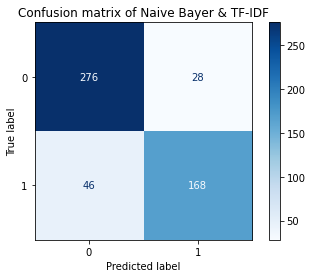

In [259]:

plot_confusion_matrix(gs_tvec_nb, X_test, y_test, cmap='Blues', values_format='d');
pl.title('Confusion matrix of Naive Bayer & TF-IDF')
print('Naive Bayer & TF-IDF\n' + classification_report(y_test,tvec_nb_pred ))

As seen above, The Logistic model outperform the Naive Bayer models in precision, recall and f1-score. Logistic Regression models also have lower false positives and false negatives than the Naive Bayer models.

Precision is the proportion of predicted positive class (Nvidia) that are actually positive, of which both the CountVectorizer Logistic and TF-IDF Logistic outperformed (0.9) the CountVectorizer Naive Bayer and  TF-IDF Naive Bayer (0.88 and 0.86).

Recall is the proportion of positive class  that were predicted correctly. In this case,  Count Vectorizer Logistic and Naive Bayes and TF-IDF Naive Bayer perform similar with 0.88  

Lastly, the F1-score is simply the harmonic mean of recall and precision ie a higher score and it is better for both Logistic models. 


|**Model| Train accuracy| Test accuracy|Precision|Recall|F1-Score|ROC AUC**|
|:---|:---:|:---:|:---:|:---:|:---:|---:|
|CountVectorizer & Logistic Regression |0.92|0.895|0.9|0.88|0.89|0.884|
|TF-IDF & Logistic Regression|0.91|0.891|0.9|0.88|	0.88|	0.88|
|CountVectorizer & Naive Bayes|0.907|0.882|0.882|0.88|0.88 |0.882|
|TF-IDF & Naive Bayes|	0.89|0.85|0.86|0.85|0.85|0.85|    
  

We use the area under the ROC curve to quantify the gap between our distributions. The greater the area under the blue curve, the better separated our distributions are. In other words, the higher the ROC AUC, the better our model is at differentiating between the 2 subreddits. 
- We will plot the accuracy for ROC AUC for the best score - Count Vectorizer Logistic Regression 

In [260]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.
pred_proba = [i[1] for i in gs_cvec_lr.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

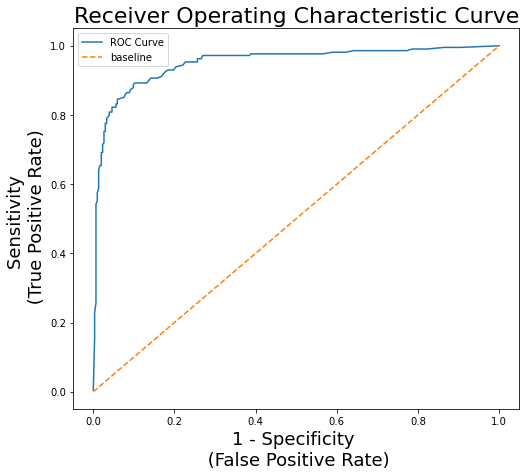

In [261]:
# Create figure.
plt.figure(figsize = (8,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity \n (True Positive Rate)', fontsize=18)
plt.xlabel('1 - Specificity \n (False Positive Rate)', fontsize=18)

# Create legend.
plt.legend(fontsize=10);


 Logistic Regression models across all evaluation metrics, accuracy, precision, recall, F1-score and ROC AUC. In the context of our business problem, we need to find whether the post is coming from Nvida or Amd.  Since both false positives and false negatives are equally as bad, we will not prioritise precision, recall and F1-score. Instead, we will use accuracy and ROC AUC to select our model.

Count Vectorizere Logistic Model has outperformed with accuracy(0.89) and ROC AUC (0.884).  This is well above our baseline score of 0.586.We has choosen Count Vectorizer Logistic Regression based on accuracy and ROC AUC scores. 


## Identifying the Most Predictive Words

In [279]:
# Save the words obtained from Count Vectorizer logistic in a dataframe
coef_df = pd.DataFrame(gs_cvec_lr.best_estimator_.named_steps['cvec'].get_feature_names(), columns=['word'])
# Save the coefficients in the same dataframe
coef_df['coef'] = gs_cvec_lr.best_estimator_.named_steps['lr'].coef_.tolist()[0]
# Find the top 20 predictive words
coef_df.sort_values('coef').head(10)

,word,coef
110,fe,-0.778062
360,ti,-0.691636
145,gtx,-0.685821
341,super,-0.614509
301,rtx,-0.571293
102,evga,-0.517685
366,tv,-0.485549
7,aib,-0.451121
120,founder,-0.441293
52,card,-0.433793


In [280]:
top_coef = coef_df.sort_values('coef').head(10)

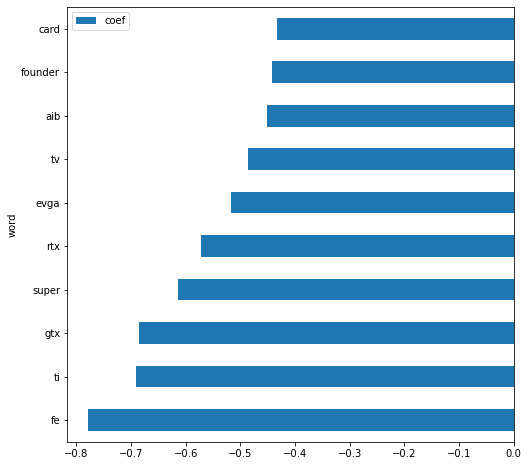

In [281]:
top_coef.plot(y='coef', x='word', kind='barh', figsize=(8,8));

#### Words with higher coefficient values are those that are more important in predicting the positive True  class of Nvidia The bar chart above shows the top 10 most important words in predicting the positive class e.e gtx, rtc and ti.

## Misclassified Data

In [265]:
# Create a dataframe consisting of only the test data
test_df = df.loc[y_test.index,:]

# Insert a column for the predictions
test_df['pred'] = cvec_lr_pred
test_df.shape

(518, 9)

In [266]:
# Create a column that indicates if the post was correctly classified or not
test_df['correctly_classified'] = (test_df['pred']==test_df['subreddit'])

# We have misclassified posts
test_df[test_df['correctly_classified']==False].shape

(54, 10)

In [267]:
# View the first 5 misclassified posts
test_df[test_df['correctly_classified']==False].head(5)

,subreddit,selftext,title,num_comments,selftext_clean,title_clean,selftext_title_clean,selftext_len,pred,correctly_classified
1592,1,"I am looking but can't find any solid answer, ...",When is RDNA2 coming out?,13,look find solid answer anyon know,rdna come,look find solid answer anyon know rdna come,6,0,False
345,0,I have Titans with both 90.02.1E.00.02 and 9...,Is there a reason to upgrade the BIOS on a Tit...,5,titan e reason updat older one slightli newer ...,reason upgrad bio titan rtx newer oem bio,titan e reason updat older one slightli newer ...,22,1,False
2396,1,Does AMD have a set date? Or have they just be...,When are the new AMD Graphics Cards being anno...,64,set date wait see gonna first ball court,new graphic card announc,set date wait see gonna first ball court new g...,8,0,False
1918,1,I have a Gsync Ultimate monitor (PG35VQ) and w...,Is RDNA2 a viable option if I have a Gsync Ult...,10,gsync ultim monitor pg vq want upgrad graphic ...,rdna viabl option gsync ultim monitor,gsync ultim monitor pg vq want upgrad graphic ...,21,0,False
2317,1,"Hello Guys,\n\nThis is my first post on reddit...",Is CPU Bottelneck affect the ML/ DL like Tenso...,14,hello guy first post reddit henc pleas ignor m...,bottelneck affect ml dl like tensorflow model ...,hello guy first post reddit henc pleas ignor m...,150,0,False


In [268]:
# Write a function to tokenise the cleaned text and plot a barplot of the top 20 most frequently occuring words

def barplot_cvec(pred, title, color):
    words_series = test_df[(test_df['correctly_classified']==False) & (test_df['pred']==pred)]['selftext_title_clean']
    
    # Instantiate Count Vectorizer 
    cvec = CountVectorizer(stop_words='english')
    
    # Save the tokens in a dataframe
    cvec_df = pd.DataFrame(cvec.fit_transform(words_series).todense(), columns=cvec.get_feature_names())
    sum_words = cvec_df.sum(axis=0) # Sum up the no. of occurences for each word
    top_words = sum_words.sort_values(ascending=False).head(10)
    top_words.sort_values(ascending=True).plot(kind='barh', figsize=(10,8), color=color)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlim(0,30)

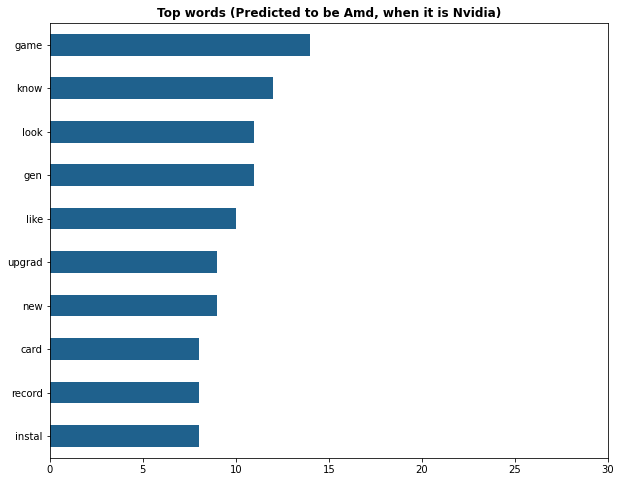

In [269]:
barplot_cvec(pred=1, title='Top words (Predicted to be Amd, when it is Nvidia)', color='#1F618D')

In [270]:
test_df.loc[(test_df['correctly_classified']==False) & (test_df['pred']==1)]

,subreddit,selftext,title,num_comments,selftext_clean,title_clean,selftext_title_clean,selftext_len,pred,correctly_classified
345,0,I have Titans with both 90.02.1E.00.02 and 9...,Is there a reason to upgrade the BIOS on a Tit...,5,titan e reason updat older one slightli newer ...,reason upgrad bio titan rtx newer oem bio,titan e reason updat older one slightli newer ...,22,1,False
776,0,"Hello redditors,\n\nSo I currently have a 2060...",Swapping out gpus,11,hello redditor current new seri come look upgr...,swap gpu,hello redditor current new seri come look upgr...,49,1,False
484,0,"So, I got feeling all nostalgic about video ca...",A Graphic Matrix Of Cards Owned Through The Ye...,20,got feel nostalg video card own year decid mak...,graphic matrix card own year,got feel nostalg video card own year decid mak...,45,1,False
146,0,I recently started to stream and i have remad...,nvidia game filter in OBS,9,recent start stream remad game filter set nvdi...,game filter ob,recent start stream remad game filter set nvdi...,77,1,False
800,0,Hello r/nvidia I've recently had a noice payda...,Upgrading soon,1,hello r recent noic payday think upgrad new se...,upgrad soon,hello r recent noic payday think upgrad new se...,48,1,False
709,0,I’ve never bought a GPU on launch before but a...,Should I buy on launch day if I won’t finish m...,12,never bought launch debat time hope get help p...,buy launch day finish build later year,never bought launch debat time hope get help p...,52,1,False
860,0,"Hey Guys, i am a little bit concerned with the...",µATX Ram clearance concerns with the 3080,1,hey guy littl bit concern clearanc backplat ra...,atx ram clearanc concern,hey guy littl bit concern clearanc backplat ra...,58,1,False
804,0,Is there an easy way to automate driver instal...,How to automate driver installation?,5,easi way autom driver instal want check everi ...,autom driver instal,easi way autom driver instal want check everi ...,45,1,False
262,0,Does anyone have any recommendations for an 80...,Budget Suggestions,2,anyon recommend usd desktop budget,budget suggest,anyon recommend usd desktop budget budget suggest,5,1,False
455,0,I own an older version of the standard nVidia ...,Comparison of new Shield vs. old shield (stand...,5,older version standard shield one look like pr...,comparison new shield vs old shield standard v...,older version standard shield one look like pr...,24,1,False


In [271]:
# Example of a misclassified post - predicted to be Amd, when it is actually Nvidia
# Notice that the word 'character' appears here - a strong predictive word for Nvidia
test_df[test_df['correctly_classified']==False].loc[1016]['selftext']

"(ANSWERED)\n\nI'm personally a fan of the ASUS ROG stuff.  I have an IX Hero right now which says is 3rd gen PCIe.\n\nSo i'm looking at their lineup of latest boards and even the highest end XII Extreme is still only 3rd Generation PCIe.\n\nWhen can we expect motherboards to catch up to RTX 3000 cards being built for 4th generation PCIe?  Is there other good quality gaming motherboards that have 4th gen for Intel 10gen CPUs\n\n&amp;#x200B;\n\nAnswer for those like me wondering why you can't find Intel board with Gen4:\n\nIntel 10th gen CPUs don't have support for PCIe gen4 so intel mobo's only have gen3 PCIe.\n\nIntel 11th gen CPUs are suppose to have it though.\n\nAMD processors have had it for a while so you will find Gen4 PCIe slots on AMD mobos.  \n\nSo as of the time of the RTX 3000 card releases, AMD systems will be able to make the most out of those new GPUs.    If you're on Intel,  3000 cards will work in Gen3 ports but i'm not sure at what kind of gaming that extra bandwidth 


- Words like |**'gen' and 'card'**| are strong predictive words for class 1. As these are the top words appearing in these documents, our model has misclassified these documents to be in Amd, when they are in fact belonging to Nvidia.
- Misclassifications could be reduced if the model was trained on more subreddit posts.

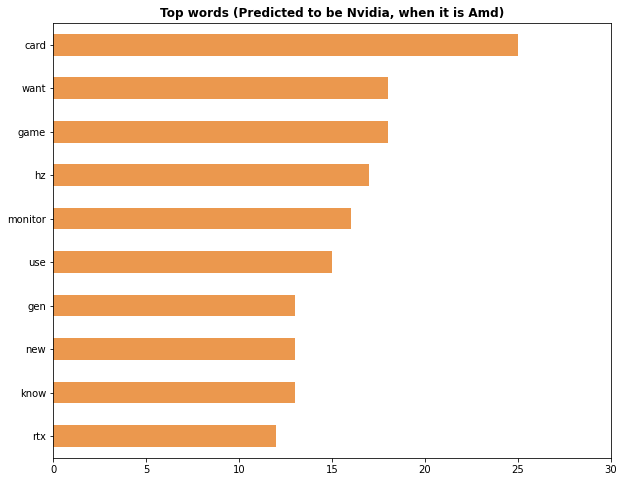

In [282]:
barplot_cvec(pred=0, title='Top words (Predicted to be Nvidia, when it is Amd)', color='#EB984E')

## Conclusion and Recommendations¶
In order to classify the subreddits Nvidia and AMD-  the data science team at Netflix built 4 models 
- Count Vectorizer & Logistic Regression, TF-IDF & Logistic Regression, CountVectorizer & Naive Bayes and TF-IDF & Naive Bayes. After fine-tuning the hyperparameters of our models, the CountVectorizer & Logistic Regression  classifier was selected on the basis of its high accuracy and high AUC scores. The model achieved an accuracy of 0.89 on the test set, outperforming the baseline score of 0.587. The model achieved accuracty of 0.89 and ROC AUC of 0.884. 


 Due to some internal system failure caused the data of posts to get mixed up and loose the classification. Given that the team has managed to build a classification model, Nvidia product managers can now look back at the database and safely identify posts which belong to Nvidia or Amd. This keeps product managers well-informed on what content are coming from Amd or Nvidia posts.  A better understanding of customer discussion of likes and dislikes will help the team to make a better decision on improvement of next generation of GPU. 

|**Improvements**|: 

- In order to reduce misclassification, we can collect more training data to make better train the model 
- Once more data is obtained, other classification models like SVM, KNN and Random Forests can be used. 
- We can try using other hyperparameters to improve the accuracy and AUC ROC score